In [1]:
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import math
from torch.autograd import Variable

class LinearL0(nn.Linear):
    r'''
        Linear layer with L0 norm regularization.

        Paper: 
            Louizos, C., Welling, M., & Kingma, D. P. (2017). 
            Learning sparse neural networks through $ L_0 $ regularization. 
            arXiv preprint arXiv:1712.01312.

        Class highly inspirired by the original implementation:
            https://github.com/AMLab-Amsterdam/L0_regularization/blob/master/l0_layers.py

        Args:
            in_features: number of features in the input tensor
            out_features: number of features in the output tensor
            bias: If set to False, the layer will not learn an additive bias.
                Default: True
            weight_decay: weight decay for L2 regularization
            droprate_init: dropout rate for the initial dropout mask, the weight gates
            temperature: temperature for the Concrete Distribution gate
            lamba: lambda for the L0 regularization
            local_rep: Whether we will use a separate gate sample per element in the minibatch
    '''
    def __init__(self, in_features, out_features, bias=True, weight_decay=1., droprate_init=0.5, temperature=.1,
                 lamba=1., local_rep=True, **kwargs) -> None:
        super(LinearL0, self).__init__(in_features, out_features, bias=bias, **kwargs)
        
        logit_drp_init = math.log(1 - droprate_init) - math.log(droprate_init)
        self.qz_loga = nn.Parameter(torch.FloatTensor(in_features).normal_(logit_drp_init, .2))

        self.weight_decay = weight_decay
        self.lambda_ = lamba
        self.temperature = temperature
        self.local_rep = local_rep
        
        # Attributes for Concrete Distribution
        self.limit_a, self.limit_b, self.eps = -.1, 1.1, 1e-6

    def forward(self, x: Tensor) -> Tensor:
        if self.local_rep or not self.training:
            z = self.sample_z(x.size(0), sample=self.training)
            xin = x.mul(z)
            output = F.linear(xin, self.weight, self.bias)
        else:
            weights = self.sample_weights()
            output = F.linear(x, weights, self.bias)
        return output

    def constrain_parameters(self, **kwargs):
        self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

    def sample_z(self, batch_size, sample=True):
        r'''
            Sample the hard-concrete gates for training and use a deterministic value for testing
        '''
        if sample:
            float_tensor = torch.cuda.FloatTensor if self.qz_loga.is_cuda else torch.FloatTensor
            eps = self.get_eps(float_tensor(batch_size, self.in_features))
            z = self.quantile_concrete(eps)
            return F.hardtanh(z, min_val=0, max_val=1)
        else:  # mode
            pi = torch.sigmoid(self.qz_loga).view(1, self.in_features).expand(batch_size, self.in_features)
            return F.hardtanh(pi * (self.limit_b - self.limit_a) + self.limit_a, min_val=0, max_val=1)

    def sample_weights(self):
        z = self.quantile_concrete(self.get_eps(self.in_features))
        mask = F.hardtanh(z, min_val=0, max_val=1) # Hard concrete gate
        return mask.view(1, self.in_features) * self.weight

    def get_eps(self, size):
        r'''
            Uniform random numbers for the concrete distribution
        '''
        float_tensor = torch.cuda.FloatTensor if self.qz_loga.is_cuda else torch.FloatTensor
        eps = Variable(float_tensor(size).uniform_(self.eps, 1-self.eps))
        return eps
        
    def quantile_concrete(self, x):
        r'''
            Implements the quantile, aka inverse CDF, 
            of the 'stretched' concrete distribution
        '''
        y = torch.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature)
        return y * (self.limit_b - self.limit_a) + self.limit_a

    def cdf_qz(self, x):
        r'''
            Implements the CDF of the 'stretched' concrete distribution
        '''
        xn = (x - self.limit_a) / (self.limit_b - self.limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return torch.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=self.eps, max=1 - self.eps)

    def _reg_w(self):
        r'''
            Expected L0 norm under the stochastic gates, takes into account 
            and re-weights also a potential L2 penalty
        '''
        logpw_col = torch.sum(- (.5 * self.weight_decay * self.weight.pow(2)) - self.lambda_, 0)
        logpw = torch.sum((1 - self.cdf_qz(0)) * logpw_col)
        logpb = - torch.sum(.5 * self.weight_decay * self.bias.pow(2)) if self.bias is not None else 0
        return logpw + logpb

    def regularization(self):
        return self._reg_w()

# Experiment

In [2]:
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader

class BreastCancer(Dataset):
    r'''
        Breast Cancer Wisconsin Dataset
    '''
    def __init__(self, normalize=False):
        dataset = datasets.load_breast_cancer()
        self.data = torch.tensor(dataset.data).float()
        self.targets = torch.tensor(dataset.target)
    
        if normalize:
            self.data /= torch.max(self.data, dim=0)[0]

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def __len__(self):
        return len(self.data)

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.model = nn.Sequential(
               LinearL0(input_size, hidden_size, bias=True, weight_decay=1, droprate_init=.5, lamba=1, temperature=.1),
               nn.ReLU(inplace=True),
               LinearL0(hidden_size, hidden_size//2, bias=True, weight_decay=1, droprate_init=.5, lamba=-1e-5, temperature=.1),
               nn.ReLU(inplace=True),
               LinearL0(hidden_size//2, output_size, bias=True, weight_decay=1, droprate_init=.5, lamba=-1e-5, temperature=.1),
        )

    def forward(self, x):
        return self.model(x)

    def regularization(self, reg_factor = 1e-4):
        reg = 0.
        for module in self.modules():
            if isinstance(module, LinearL0):
                reg = reg  + (-reg_factor * module.regularization())
        return reg

    def constrain_parameters(self):
        for module in self.modules():
            if isinstance(module, LinearL0):
                module.constrain_parameters()

In [4]:
from tqdm import tqdm

def train(model, dataset, batch_size = 128, n_epochs=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % 1},
        )

    for _ in epoch_iterator:
        for idx, (inputs, targets) in enumerate(loader):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            targets = targets.to(device)
            pred = model(inputs)

            loss = criterion(pred, targets) + model.regularization()
            loss.backward()
            optimizer.step()

            # Clamp the parameters
            model.constrain_parameters()

            if idx % 10 == 0:
                epoch_iterator.set_postfix(tls="%.4f" % loss.item())

    return model

In [5]:
dataset = BreastCancer(normalize=True)

eval_len = len(dataset) // 5 # 20% of the dataset
train_set, eval_set = torch.utils.data.random_split(dataset, [len(dataset) - eval_len, eval_len])

loader = DataLoader(eval_set, batch_size=128, shuffle=True)

In [18]:
model = Model(30, 48, 2)
train(model, train_set, batch_size=128, n_epochs=400)

100%|██████████| 400/400 [00:18<00:00, 21.54epoch/s, tls=0.3352]


Model(
  (model): Sequential(
    (0): LinearL0(in_features=30, out_features=48, bias=True)
    (1): ReLU(inplace=True)
    (2): LinearL0(in_features=48, out_features=24, bias=True)
    (3): ReLU(inplace=True)
    (4): LinearL0(in_features=24, out_features=2, bias=True)
  )
)

In [19]:
x, y = next(iter(loader))
model.eval()
result = torch.argmax(model(x.cuda()),axis=1)
print('Accuracy:', (result == y.cuda()).sum().item() / len(y))

Accuracy: 0.9380530973451328


In [20]:
torch.sigmoid(model.model[0].qz_loga.detach()).cpu().numpy()

array([0.5079658 , 0.37383413, 0.59171605, 0.655487  , 0.4456058 ,
       0.4524926 , 0.62579685, 0.689238  , 0.33892947, 0.4402495 ,
       0.5190196 , 0.31015986, 0.5664475 , 0.6451608 , 0.4182656 ,
       0.35272372, 0.4420108 , 0.2773563 , 0.38249415, 0.4432401 ,
       0.4938804 , 0.41990495, 0.4934271 , 0.7048411 , 0.3952287 ,
       0.63159734, 0.47799972, 0.66821533, 0.43845588, 0.3908939 ],
      dtype=float32)

In [21]:
first_layer = model.model[0]
weight = first_layer.sample_weights()

In [22]:
samples = []
for i in range(1000):
    samples.append(first_layer.sample_weights())

In [23]:
test = torch.stack(samples).detach()

test = test.mean(axis=0)

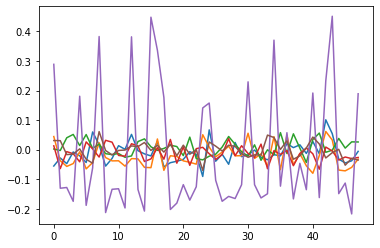

In [24]:
from matplotlib import pyplot as plt 
import numpy as np 

values = test.cpu().numpy()
for i in np.linspace(0, 29, 6, dtype=int):
    plt.plot(values[:, i])

# Feature Ranking
Muestras con alta varianza las considero importantes! Parece que coincide con los valores esperados de otras pruebas.

In [37]:
x, y = next(iter(loader))
first_layer = model.model[0]

samples = []
for i in range(1000):
    samples.append(first_layer.sample_weights())

values = torch.stack(samples).detach().mean(axis=0)
std_values = values.std(axis=0).cpu()

In [39]:
values, idx = torch.sort(std_values)
features_names = datasets.load_breast_cancer(as_frame=True).data.columns[idx.flipud().cpu()]
print(features_names)

['area error' 'worst area' 'mean concave points' 'worst concave points'
 'mean area' 'perimeter error' 'mean concavity' 'radius error'
 'worst compactness' 'concavity error' 'worst concavity'
 'fractal dimension error' 'worst radius' 'mean perimeter'
 'worst perimeter' 'mean fractal dimension' 'smoothness error'
 'mean compactness' 'mean radius' 'compactness error' 'worst symmetry'
 'concave points error' 'texture error' 'worst fractal dimension'
 'symmetry error' 'mean smoothness' 'worst texture' 'mean texture'
 'worst smoothness' 'mean symmetry']
